# **Environment Setup**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import pickle

# **Loading and seeing the dataset**

In [2]:
# Load the dataset
df = pd.read_csv('/content/players_22.csv')

/tmp/ipython-input-1343481147.py:2: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/players_22.csv')


In [3]:
df.head()

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,...,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,...,50+3,50+3,50+3,61+3,19+3,https://cdn.sofifa.net/players/158/023/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png
1,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,92,92,119500000.0,270000.0,32,...,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png
2,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,...,53+3,53+3,53+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/22_120.png,https://cdn.sofifa.net/teams/11/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png
3,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,"LW, CAM",91,91,129000000.0,270000.0,29,...,50+3,50+3,50+3,62+3,20+3,https://cdn.sofifa.net/players/190/871/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,NaN,https://cdn.sofifa.net/flags/br.png
4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,125500000.0,350000.0,30,...,69+3,69+3,69+3,75+3,21+3,https://cdn.sofifa.net/players/192/985/22_120.png,https://cdn.sofifa.net/teams/10/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1325/60.png,https://cdn.sofifa.net/flags/be.png


In [4]:

df.shape

(19239, 110)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Columns: 110 entries, sofifa_id to nation_flag_url
dtypes: float64(16), int64(44), object(50)
memory usage: 16.1+ MB


In [6]:
df.isnull().sum()

,0
sofifa_id,0
player_url,0
short_name,0
long_name,0
player_positions,0
...,...
player_face_url,0
club_logo_url,61
club_flag_url,61
nation_logo_url,18480


# **Data Preprocessing**

### **Feature Engineering and Selection**

In [7]:
# I will create a new feature called 'growth_potential' here
# This tells us how much better a player can get in the future
df['growth_potential'] = df['potential'] - df['overall']

In [8]:
# select specific columns for clustering

selected_features = [
    'short_name',
    'overall',
    'potential',
    'wage_eur',
    'value_eur',
    'age',
    'passing',
    'shooting',
    'dribbling',
    'growth_potential'
]


In [9]:
# Create a new dataframe with only these columns
df_cluster = df[selected_features].copy()

### **Cleaning Missing Values**

In [10]:
# I used KNN imputer to handle missing values
# KNN only works on math, so we must isolate the numbers first.
numeric_features = [
    'overall', 'potential', 'wage_eur', 'value_eur',
    'age', 'passing', 'shooting', 'dribbling', 'growth_potential'
]

In [11]:
# See the Shape of the original data
print(f"Original Data Shape: {df_cluster.shape}")

Original Data Shape: (19239, 10)


In [12]:
# Check for missing values for the columns I chose for clustering

print(f"Missing values before cleaning:\n{df_cluster[numeric_features].isnull().sum()}")

Missing values before cleaning:
overall                0
potential              0
wage_eur              61
value_eur             74
age                    0
passing             2132
shooting            2132
dribbling           2132
growth_potential       0
dtype: int64


In [13]:
df_cluster[numeric_features].head(10)

,overall,potential,wage_eur,value_eur,age,passing,shooting,dribbling,growth_potential
0,93,93,320000.0,78000000.0,34,91.0,92.0,95.0,0
1,92,92,270000.0,119500000.0,32,79.0,92.0,86.0,0
2,91,91,270000.0,45000000.0,36,80.0,94.0,88.0,0
3,91,91,270000.0,129000000.0,29,86.0,83.0,94.0,0
4,91,91,350000.0,125500000.0,30,93.0,86.0,88.0,0
5,91,93,130000.0,112000000.0,28,NaN,NaN,NaN,2
6,91,95,230000.0,194000000.0,22,80.0,88.0,92.0,4
7,90,90,86000.0,13500000.0,35,NaN,NaN,NaN,0
8,90,92,250000.0,99000000.0,29,NaN,NaN,NaN,2
9,90,90,240000.0,129500000.0,27,83.0,91.0,83.0,0


In [14]:
# Apply KNN Imputation
# The algorithm looks for the 5 nearest neighbors to fill in the blanks
imputer = KNNImputer(n_neighbors=5)
df_filled_array = imputer.fit_transform(df_cluster[numeric_features])

In [15]:
# Update the DataFrame with the new full values
df_cluster[numeric_features] = df_filled_array


In [16]:
# See the missing value of the data after KNN imputation
print(f"\nMissing values after KNN Imputation:\n\n{df_cluster[numeric_features].isnull().sum()}")


Missing values after KNN Imputation:

overall             0
potential           0
wage_eur            0
value_eur           0
age                 0
passing             0
shooting            0
dribbling           0
growth_potential    0
dtype: int64


In [17]:
df_cluster[numeric_features].head(10)

,overall,potential,wage_eur,value_eur,age,passing,shooting,dribbling,growth_potential
0,93.0,93.0,320000.0,78000000.0,34.0,91.0,92.0,95.0,0.0
1,92.0,92.0,270000.0,119500000.0,32.0,79.0,92.0,86.0,0.0
2,91.0,91.0,270000.0,45000000.0,36.0,80.0,94.0,88.0,0.0
3,91.0,91.0,270000.0,129000000.0,29.0,86.0,83.0,94.0,0.0
4,91.0,91.0,350000.0,125500000.0,30.0,93.0,86.0,88.0,0.0
5,91.0,93.0,130000.0,112000000.0,28.0,71.4,71.0,72.2,2.0
6,91.0,95.0,230000.0,194000000.0,22.0,80.0,88.0,92.0,4.0
7,90.0,90.0,86000.0,13500000.0,35.0,71.6,69.8,72.6,0.0
8,90.0,92.0,250000.0,99000000.0,29.0,71.4,71.0,72.2,2.0
9,90.0,90.0,240000.0,129500000.0,27.0,83.0,91.0,83.0,0.0


We can see that there are no null values anymore.

### **Scaling**

In [18]:
# Prepare Data for the Model (Drop text columns)
X = df_cluster.drop(['short_name'], axis=1)

In [19]:
# I used StandardScaler for scaling
# 'wage_eur' is huge (e.g., 200,000) and 'age' is small (e.g., 25).
# We must scale them so they have equal weight.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Convert back to DataFrame for viewing
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\nData is ready for Clustering!")
print(X_scaled_df.head())


Data is ready for Clustering!
    overall  potential   wage_eur  value_eur       age   passing  shooting  \
0  3.957501    3.60178  15.991580   9.887369  1.851089  3.431334  2.922139   
1  3.812154    3.43747  13.420410  15.347225  1.429869  2.216441  2.922139   
2  3.666806    3.27316  13.420410   5.545796  2.272309  2.317682  3.068643   
3  3.666806    3.27316  13.420410  16.597072  0.798039  2.925129  2.262868   
4  3.666806    3.27316  17.534282  16.136602  1.008649  3.633817  2.482625   

   dribbling  growth_potential  
0   3.468137         -0.962235  
1   2.515944         -0.962235  
2   2.727542         -0.962235  
3   3.362338         -0.962235  
4   2.727542         -0.962235  


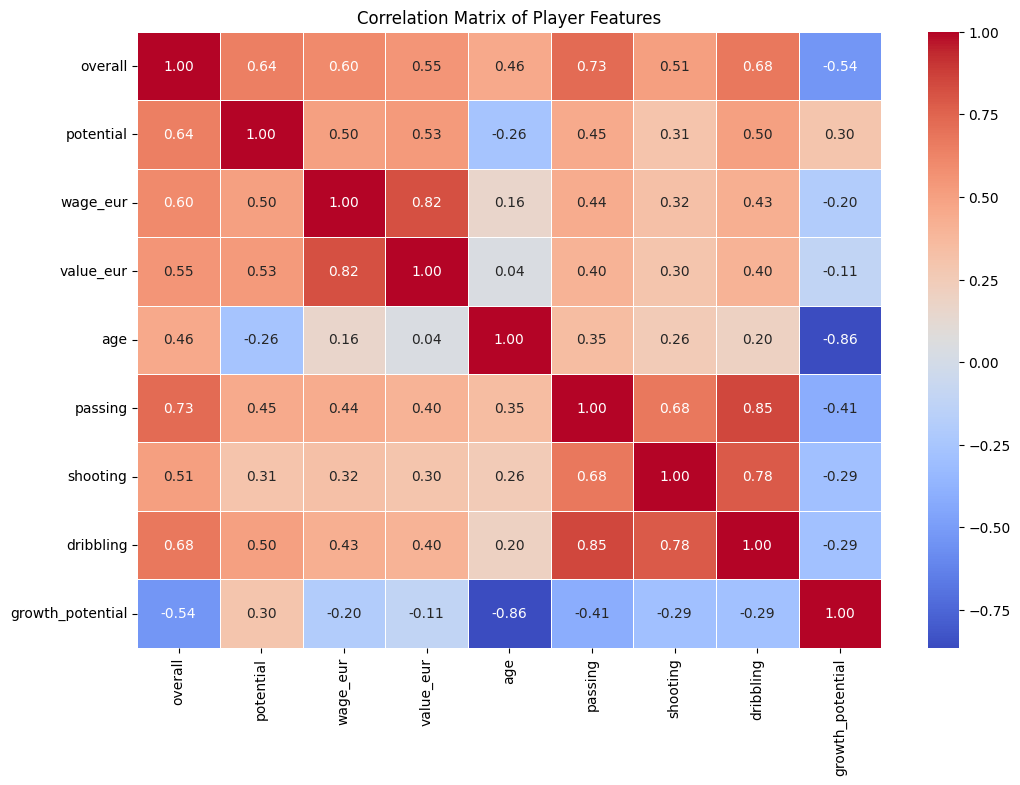

In [21]:
# To see the correlation between features, let's make a correlation matrix.
# This helps us see which features overlap (e.g., Dribbling vs. Passing)
plt.figure(figsize=(12, 8))
correlation_matrix = df_cluster[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Player Features')
plt.show()

# **Hyperparameter Tuning (Finding K)**

In [22]:
# To find the best K, I will test different numbers of clusters (from 2 to 10)
# to see which one fits the data best.
k_range = range(2, 11)
inertia_values = []
silhouette_scores = []


for k in k_range:
    # Train a temporary model for each K
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_scaled)

    # Elbow Method: Store the "Inertia" (Error rate)
    inertia_values.append(kmeans_temp.inertia_)

    # Silhouette Score: Measures how well separated the groups are
    # (Higher score is better)
    score = silhouette_score(X_scaled, kmeans_temp.labels_)
    silhouette_scores.append(score)
    print(f"K={k}. Silhouette Score: {score:.4f}")

K=2. Silhouette Score: 0.2772
K=3. Silhouette Score: 0.2834
K=4. Silhouette Score: 0.2584
K=5. Silhouette Score: 0.2514
K=6. Silhouette Score: 0.2398
K=7. Silhouette Score: 0.2286
K=8. Silhouette Score: 0.2176
K=9. Silhouette Score: 0.2108
K=10. Silhouette Score: 0.2142


We can see that we have the highest value at k=3.

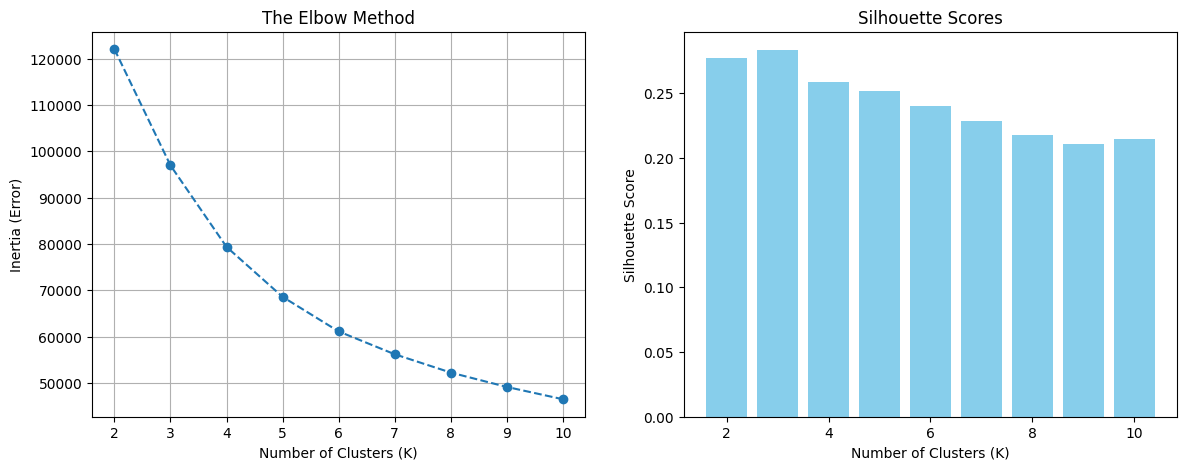

In [23]:
# Plotting the Elbow Graph
plt.figure(figsize=(14, 5))

# Plot 1: The Elbow Curve
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia_values, marker='o', linestyle='--')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Error)')
plt.grid(True)

# Plot 2: Silhouette Scores
plt.subplot(1, 2, 2)
plt.bar(k_range, silhouette_scores, color='skyblue')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.show()

Based on the graph, we can clearly see that k=3 is the best k for our clustering.

In [24]:
optimal_k = 3

In [25]:
# train the final model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_final.fit(X_scaled)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [26]:
# Add the results back to our original list
# Now every player has a "Cluster" number (0, 1, 2)
df_cluster['Cluster'] = kmeans_final.labels_

In [27]:
# Training for our model is Completed
print(df_cluster[['short_name', 'overall', 'value_eur', 'Cluster']].head(5))

          short_name  overall    value_eur  Cluster
0           L. Messi     93.0   78000000.0        2
1     R. Lewandowski     92.0  119500000.0        2
2  Cristiano Ronaldo     91.0   45000000.0        2
3          Neymar Jr     91.0  129000000.0        2
4       K. De Bruyne     91.0  125500000.0        2


### **Visualization (PCA)**

In [28]:
# Reduce data to 2 Dimensions using PCA
# This allows us to visualize the 7-dimensional data on a flat screen
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

In [29]:
# add PCA coordinates to our DataFrame
df_cluster['PCA1'] = pca_components[:, 0]
df_cluster['PCA2'] = pca_components[:, 1]

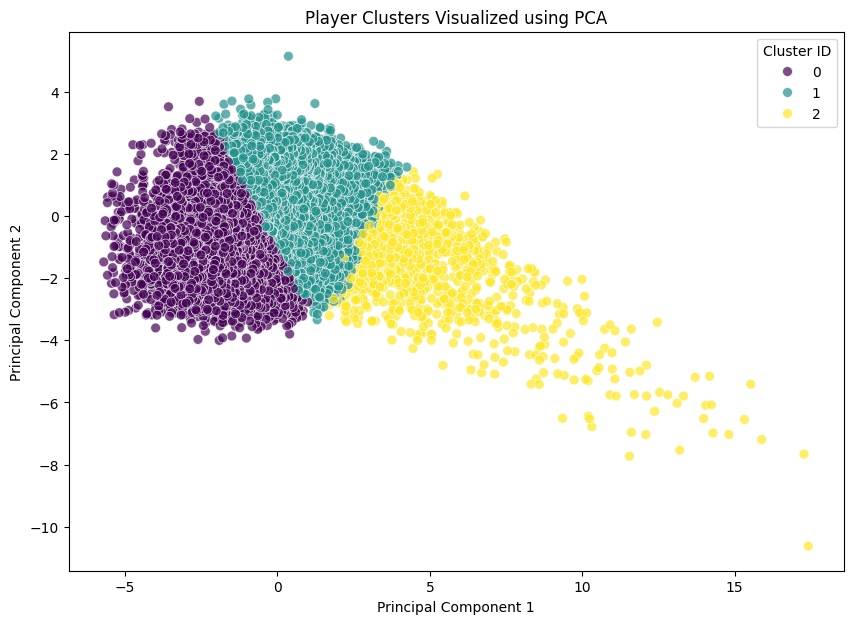

In [30]:
# Scatter Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='Cluster', # Color points by their Cluster number
    data=df_cluster,
    palette='viridis',
    s=50,
    alpha=0.7 # Transparency helps see overlapping points
)
plt.title('Player Clusters Visualized using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster ID')
plt.show()

In [31]:
# Cluster Summary
# We add 'numeric_only=True' to ignore the player names
cluster_summary = df_cluster.groupby('Cluster')[selected_features].mean(numeric_only=True)

print("\nCluster Summaries (Mean Values):")
print(cluster_summary)


Cluster Summaries (Mean Values):
           overall  potential      wage_eur     value_eur        age  \
Cluster                                                                
0        60.261333  70.058559   2293.137280  7.908148e+05  21.721202   
1        68.234076  70.388933   7592.492038  1.807669e+06  27.757564   
2        78.717949  81.682336  56563.176638  2.168634e+07  26.339031   

           passing   shooting  dribbling  growth_potential  
Cluster                                                     
0        49.197021  42.562681  55.188262          9.797226  
1        61.169347  57.339192  65.717715          2.154857  
2        71.909402  67.618661  76.183048          2.964387  


### **Save Model For Stremlit**

In [32]:
model_filename = 'kmeans_model.pkl'
scaler_filename = 'scaler.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(kmeans_final, file)

with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

print(f"\nFiles saved successfully: {model_filename}, {scaler_filename}")


Files saved successfully: kmeans_model.pkl, scaler.pkl
